## ENSEMBLE MODEL (LR + SVM + XGB + LSTM)

In [6]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# Load Logistic Regression model and vectorizer
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

# Load SVM model and vectorizer
with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

# Load XGBoost model, vectorizer, and label encoder
with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# Load LSTM model, tokenizer, and label encoder
lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' column exists
if 'cleaned_text' not in data.columns:
    raise ValueError("The dataset must have a 'cleaned_text' column.")

# Remove rows with missing values in 'cleaned_text'
data.dropna(subset=['cleaned_text'], inplace=True)

# Split features and target
X_test = data['cleaned_text']
y_test = data['mental_health_issue']

# Encode target labels
y_test = label_encoder.transform(y_test)

# Process the text for each model
X_test_lr = lr_vectorizer.transform(X_test)  # Logistic Regression vectorizer
X_test_svm = svm_vectorizer.transform(X_test)  # SVM vectorizer
X_test_xgb = tfidf_vectorizer.transform(X_test)  # XGBoost vectorizer
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)  # LSTM tokenizer

# Pad sequences for LSTM
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get predictions from the base models
lr_predictions_proba = lr_model.predict_proba(X_test_lr)  # Logistic Regression probabilities
svm_predictions_proba = svm_model.predict_proba(X_test_svm)  # SVM probabilities
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)  # XGBoost probabilities
lstm_predictions_proba = lstm_model.predict(X_test_lstm)  # LSTM probabilities

# Stack the predictions of all models to create the feature matrix for the meta-learner
stacked_features = np.hstack((lr_predictions_proba, svm_predictions_proba, xgb_predictions_proba, lstm_predictions_proba))

# Train the meta-learner (SVM as the meta-learner)
meta_learner = SVC(probability=True)  # Enable probability predictions for SVM
meta_learner.fit(stacked_features, y_test)

# Save the trained meta-learner
with open('meta_learner_svm.pkl', 'wb') as file:
    pickle.dump(meta_learner, file)

# Load the pre-trained meta-learner (if needed)
with open('meta_learner_svm.pkl', 'rb') as file:
    meta_learner = pickle.load(file)

# Predict using the meta-learner
final_predictions = meta_learner.predict(stacked_features)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, final_predictions)
report = classification_report(y_test, final_predictions, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, final_predictions))


581/581 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step
Accuracy: 97.34%
Classification Report:
               precision    recall  f1-score   support

     anxiety       0.97      0.96      0.96      1999
     bipolar       0.95      0.90      0.92      1941
  depression       0.95      0.96      0.96      1959
      normal       0.98      1.00      0.99     10679
        ptsd       0.97      0.96      0.97      1987

    accuracy                           0.97     18565
   macro avg       0.96      0.95      0.96     18565
weighted avg       0.97      0.97      0.97     18565

Confusion Matrix:
 [[ 1913    17    32    16    21]
 [    8  1743    28   149    13]
 [   26    27  1875    12    19]
 [    6    41     3 10627     2]
 [   21    15    28     9  1914]]


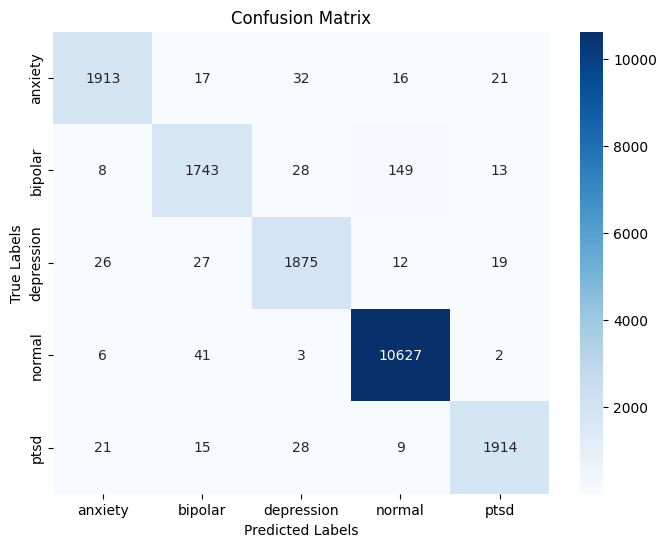

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


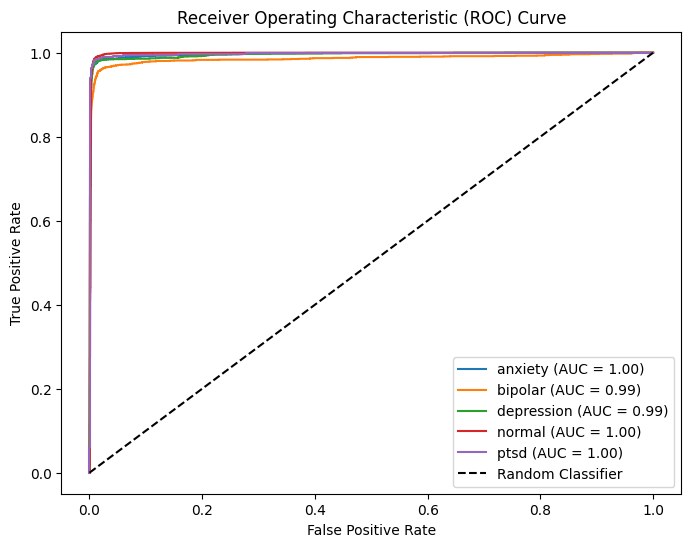

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the output for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))

# Get the predicted probabilities for all classes
y_pred_prob = meta_learner.predict_proba(stacked_features)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

# For each class, compute ROC curve and AUC
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Finalize the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
